In [0]:
from pathlib import Path
import pickle
import numpy as np

import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import pandas as pd

#**Building a CNN model for classification of the given dataset**


In [0]:
dest = Path('Data')  #creating a folder to load data into 
dest.mkdir(parents=True, exist_ok=True)

Loading the data from file into variables and checking out the labels.

In [0]:
with open(dest/'train_image.pkl', 'rb') as f:
    data_img = np.array(pickle.load(f),dtype='float32').reshape(8000,28,28)  # reshaping the each data into 2D matrix
with open(dest/'train_label.pkl', 'rb') as f:
    data_label = np.array(pickle.load(f))
set(data_label.flatten())  #looking at all the set of labeles

{0, 2, 3, 6}

Now the data set has 4 labels (0,2,3,6). The following function maps these valuse to default labels 0,1,2 and 3 for the convenience of model building. We then use the function on the extracted labels.

In [0]:
def map_vect(x):
  if x==0:
    return 0
  elif x==2:
    return 1
  elif x==3:
    return 2
  else:
    return 3

data_label_mapped = np.array([map_vect(x) for x in data_label])
set(data_label_mapped.flatten())

{0, 1, 2, 3}

Setting up for splitting data into train and validation set

In [0]:
data_size = len(data_img)    #total number of images
validation_split = .2  #ratio of data to be put into validation set
indices = list(range(data_size))  #getting the indices in form of list
split = int(np.floor(validation_split * data_size))  #amount of data to be split into validation set

In [0]:
random_seed= 77
np.random.seed(random_seed)
np.random.shuffle(indices)  #shuffling the indices randomly

Splitting the data into train_set and valid_set

In [0]:
train_indices, val_indices = indices[split:], indices[:split]
train_img = data_img[train_indices[:]]    #train set images
train_label = data_label_mapped[train_indices[:]]    #train set labels
valid_img = data_img[val_indices[:]]    #validarion set images
valid_label = data_label_mapped[val_indices[:]]    #validation set images

Visualising the data set using matplotlib to display images

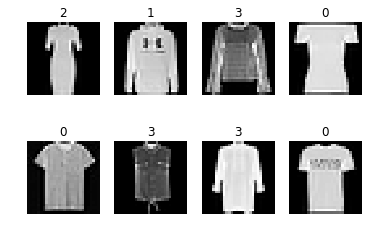

In [0]:
for i in range(1, 9):
    axis = plt.subplot(2,4,i)
    img = train_img[i]
    plt.imshow(img,cmap="gray")
    axis.set_title(str(int(train_label[i])))
    axis.axis('off')


Creating Tensor data set and data loader of train_set and validation set. 
Pytorch’s DataLoader is responsible for managing batches. You can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches and also automatically creates mini batches for you thus refactoring a lot of coding.

In [0]:
bs = 16   #batch size

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (train_img, train_label, valid_img, valid_label)
)

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)  #we are keeping batch size for validation set more as it does not require back propogation and hence less memory is needed

Below is the implementation of function used for calculating the accuracy of our model on validation set after each epoc

In [0]:
def accuracy(y_hat,y):
  _,topclass = y_hat.topk(1,dim=1) 
  topclass.view(bs*2)    #getting the predicted classes for each input image
  eq = topclass==y.view(topclass.shape)  #comparing the prediction with the actual class label
  acc = torch.mean(eq.type(torch.FloatTensor))   # calculating the accuracy
  return acc

The function below calucaltes loss of training and validation mini batch and also runs back propogation in case of training batch. If parameter opt (Optimiser) = None we know that it is validation batch and hence dont run back prop. However if opt !=None we run back prop taking the case for training batch.

In [0]:
def loss_batch(model, loss_func, x_batch, y_batch, opt=None):
    y_hat = model(x_batch)  #prediction of medel for the given batch

    loss = loss_func(y_hat, y_batch)
    acc = None

    if opt != None:     # if optimiser is passed as a parameter then we take it as the case of training batch and run back propagation
        
        #backpro
        loss.backward()
        opt.step()
        opt.zero_grad()
        
    else:               # if no optimiser is provided , we instead calculate the accuracy for the validation batch
      
        acc = accuracy(y_hat,y_batch) 
     

    return loss.item(), len(x_batch), acc

fit function implemented below trains the model for given number of epochs passed to it as parameter. It also prints the result as training loss ,validation loss and accuracy after each epoc

In [0]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
  
    model.cuda()   #instruction to train the model on gpu
 
    for epoch in range(epochs):   
        model.train()
        train_loss = 0
        
        for x_batch, y_batch in train_dl: #looping over mini batches
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()
            l, n, a = loss_batch(model, loss_func, x_batch, y_batch, opt)
            train_loss = train_loss+l
            
        train_loss = train_loss/len(train_dl) #calculating average loss

        model.eval()
        acc = None
        
        with torch.no_grad():
            losses, nums, acc = zip(
                *[loss_batch(model, loss_func, x_batch.cuda(), y_batch.cuda()) for x_batch, y_batch in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        acc = np.sum(np.multiply(acc, nums)) / np.sum(nums)

        print(epoch, train_loss, val_loss, acc ,"(Train loss, Validation loss, Validation Accuracy)")

## First model Implementation

We will quickly build a basic model and see how it is performing on the data set. We cannot have a deep/big network like vgg nets as amount of data available is not sufficient to effeciently train sucha a large model. So we will build a relatively shallow network.

X ---> Conv1 ---> Relu ---> Conv2 ---> Relu ---> BatchNorm1 ---> MaxPool ---> Conv3 --->Relu ---> Conv4 ---> Relu ---> BatchNorm2 ---> MaxPool ---> Conv5 --->Relu ---> Conv6 ---> Relu ---> BatchNorm3 ---> FC1 --->Relu ---> FC2 ---> Relu ---> FC3 ---> LogSoftmax --->Y

In [0]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1,padding = 1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1,padding = 1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding = 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1,padding = 1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1,padding = 1)
        self.bn6 = nn.BatchNorm2d(256)
        
        
        self.fc1 = nn.Linear(7*7*256,1000)
        self.fc2 = nn.Linear(1000,100)
        self.fc3 = nn.Linear(100,4)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)

        xb = F.relu(self.bn1(self.conv1(xb)))

        xb = F.relu(self.bn2(self.conv2(xb)))

        xb = self.maxpool(xb)

        xb = F.relu(self.bn3(self.conv3(xb)))

        xb = F.relu(self.bn4(self.conv4(xb)))

        xb = self.maxpool(xb)

        xb = F.relu(self.bn5(self.conv5(xb)))
        
        xb = F.relu(self.bn6(self.conv6(xb)))
        

        xb = xb.view(-1,7*7*256)
        
        xb = F.relu(self.fc1(xb))

        xb = F.relu(self.fc2(xb))
        
        xb = self.fc3(xb)
        
        xb = F.log_softmax(xb,dim=1)

        return xb

Trainig the given model for 30 epochs. We can see the model starts overfitting just after 6-7 epochs as training validation loss starts increasing .
So we can stop training the model early to prevnt over fitting

In [0]:
loss_func = nn.NLLLoss()
model = Mnist_CNN()
opt = optim.Adam(model.parameters(), lr=0.001)

fit(10, model, loss_func, opt, train_dl, valid_dl)

0 0.5831912258639932 0.5022831839323044 0.81625 (Train loss, Validation loss, Validation Accuracy)
1 0.4022861315868795 0.4528235301375389 0.82625 (Train loss, Validation loss, Validation Accuracy)
2 0.32880141797475515 0.44404417857527734 0.84125 (Train loss, Validation loss, Validation Accuracy)
3 0.2770838150661439 0.48117614567279815 0.841875 (Train loss, Validation loss, Validation Accuracy)
4 0.2391244969330728 0.4204243941605091 0.85125 (Train loss, Validation loss, Validation Accuracy)
5 0.20172451894730328 0.48005597084760665 0.83625 (Train loss, Validation loss, Validation Accuracy)
6 0.17253512552939354 0.5155504375696183 0.85 (Train loss, Validation loss, Validation Accuracy)
7 0.14410212346352635 0.46586009725928307 0.85125 (Train loss, Validation loss, Validation Accuracy)
8 0.12117835775017738 0.568631980419159 0.84875 (Train loss, Validation loss, Validation Accuracy)
9 0.10484115674160421 0.546810368001461 0.86125 (Train loss, Validation loss, Validation Accuracy)


## Second model Implementation

We will keep most of the model same, just add a bit regularization.


In [0]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.maxpool = nn.MaxPool2d(2,2)
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, stride=1,padding = 1)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1,padding = 1)
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding = 1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, stride=1,padding = 1)
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding = 1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 256, kernel_size=3, stride=1,padding = 1)
        self.bn6 = nn.BatchNorm2d(256)
        
        
        self.fc1 = nn.Linear(7*7*256,1000)
#         self.fc2 = nn.Linear(1000,100)
        self.fc3 = nn.Linear(1000,4)

    def forward(self, xb):        
        
        xb = xb.view(-1, 1, 28, 28)

        xb = F.relu(self.bn1(self.conv1(xb)))
        
        xb = F.dropout(xb,p=0.55)

        xb = F.relu(self.bn2(self.conv2(xb)))
        
        xb = F.dropout(xb,p=0.45)

        xb = self.maxpool(xb)

        xb = F.relu(self.bn3(self.conv3(xb)))
        
        xb = F.dropout(xb,p=0.35)

        xb = F.relu(self.bn4(self.conv4(xb)))
        
        xb = F.dropout(xb,p=0.25)

        xb = self.maxpool(xb)

        xb = F.relu(self.bn5(self.conv5(xb)))
        
        xb = F.dropout(xb,p=0.15)
        
        xb = F.relu(self.bn6(self.conv6(xb)))
        

        xb = xb.view(-1,7*7*256)
        
        xb = F.relu(self.fc1(xb))
        
        xb = F.dropout(xb,p=0.25)

#         xb = F.relu(self.fc2(xb))
        
#         xb = F.dropout(xb,p=0.15)
        
        xb = self.fc3(xb)
        
        xb = F.log_softmax(xb,dim=1)

        

        return xb

In [0]:
model = Mnist_CNN()
opt = optim.Adam(model.parameters(), lr=0.001)

fit(12, model, loss_func, opt, train_dl, valid_dl)

Below is generating the csv file on test image

In [0]:
with open(dest/'test_image.pkl', 'rb') as r:
    test_data = pickle.load(r)

In [0]:
test_imgs = np.array(test_data,dtype='float32').reshape(2000,28,28)
test_imgs[0].shape

(28, 28)

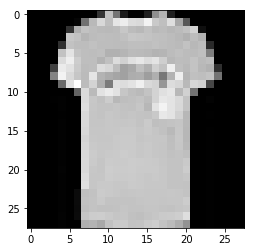

In [0]:
plt.imshow(test_imgs[0],cmap="gray")

In [0]:
labels = []
for image in test_imgs:
  image = transforms.ToTensor()(image)
  #image = torch.unsqueeze(image,dim=0)
  image = image.cuda()
  y = model(image)
  ex = torch.exp(y)
  _,top_class = ex.topk(1,dim=1)
  labels.append(top_class)

In [0]:
def map_back(x):
  if x==0:
    return 0
  elif x==1:
    return 2
  elif x==2:
    return 3
  else:
    return 6

In [0]:
final_labels = [map_back(x) for x in labels]

In [0]:
rows = []
for i in range(len(final_labels)):
    l = []
    l.append(i)
    l.append(final_labels[i])
    rows.append(l)

In [0]:
Outputs = pd.DataFrame(rows,columns=['image_index','class'])
Outputs.to_csv('Anant_Rai.csv',index = False)